# Hamiltonian-based mixflows

Here we develop the code for dealing with continuous data
via mixflows using deterministic Hamiltonian dynamics.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
def lqN(x,rho,u,N,L,eps,lq0,gradlp,momentum='laplace',xi=np.pi/16):
    if N==1: return lq0(x,rho,u)
    w=np.zeros((N,x.shape[1]))
    w[0,:]=lq0(x,rho,u)
    LJ=np.zeros(x.shape[1])
    for n in range(N-1):
        x,rho,u,tlj=flow(x,rho,u,1,L,eps,gradlp,momentum,xi,direction='bwd')
        LJ=LJ+tlj
        w[n+1,:]=lq0(x,rho,u)-LJ
    # end for
    return LogSumExp(w)-np.log(N)
    

def flow(x,rho,u,steps,L,eps,gradlp,momentum='laplace',xi=np.pi/16,direction='fwd'):
    if steps==0: return x,rho,u,np.zeros(x.shape[1])
    
    # define laplace functions
    if momentum=='laplace':
        lm = lambda rho : laplace_lm(rho)
        gradlm = lambda rho : laplace_gradlm(rho)
        Fm = lambda rho : laplace_Fm(rho)
        Qm = lambda p : laplace_Qm(p)
        
    ljs=np.zeros(x.shape[1])
    for t in range(steps):
        if direction=='fwd': x,rho,u,tljs=T_Leps_fwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        if direction=='bwd': x,rho,u,tljs=T_Leps_bwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        ljs+=tljs
    # end for
    return x,rho,u,ljs
    

def T_Leps_fwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi=np.pi/16):
    print('Starting forwards step')
    print('Initial x: '+str(x[...,0]))
    x,rho=Hamiltonian_update(x,rho,L,eps,gradlp,gradlm)
    u=(u+xi)%1
    lJ=lm(rho)
    rho=Qm((Fm(rho)+prz(x,u))%1)
    lJ=lJ-lm(rho)
    print('Final x: '+str(x[...,0]))
    print()
    return x,rho,u,lJ

def T_Leps_bwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi=np.pi/16):
    print('Starting backwards step')
    print('Initial x: '+str(x[...,0]))
    lJ=lm(rho)
    rho=Qm((Fm(rho)-prz(x,u))%1)
    lJ=lJ-lm(rho)
    u=(u-xi)%1
    x,rho=Hamiltonian_update(x,rho,L,-eps,gradlp,gradlm)
    print('Final x: '+str(x[...,0]))
    print()
    return x,rho,u,lJ

def Hamiltonian_update(x,rho,L,eps,gradlp,gradlm):
    #print('Starting Hamiltonian update')
    #print('Initial x: '+str(x))
    for l in range(L):
        rho+=eps*gradlp(x)/2
        x  -=eps*gradlm(rho)
        rho+=eps*gradlp(x)/2
    # end for
    #print('Final x: '+str(x))
    #print()
    return x,rho
    
    
def prz(x,u): return 0.5*np.sin(2*x+u[np.newaxis,:])+0.5
def laplace_lm(rho): return -np.sum(np.abs(rho),axis=0)-np.log(2)
def laplace_gradlm(rho): return -np.sign(rho)
def laplace_Fm(rho): return -0.5*np.sign(rho)*np.exp(-np.sign(rho)*rho)+0.5+0.5*np.sign(rho)
def laplace_Qm(p): return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5))


def LogSumExp(w):
    # LogSumExp trick
    #
    # inputs:
    #    w : (N,d) array, exponents
    #
    # outputs:
    #    w' : (N,d) array, log(sum(exp(w)))
    wmax = np.amax(w,axis=0)
    return wmax + np.log(np.sum(np.exp(w-wmax[np.newaxis,:]),axis=0))

In [17]:
# define the target density and score
def lp(x): return -0.5*np.sum(x**2,axis=0)-0.5*x.shape[0]*np.log(2*np.pi)
def gradlp(x): return -x

# reference distribution
sd=5
def lq0(x,rho,u): 
    x_lp   = -0.5*np.sum((x-5)**2,axis=0)/sd**2-0.5*x.shape[0]*np.log(2*np.pi*sd**2)
    rho_lp = -0.5*np.sum(rho**2,axis=0)    -0.5*rho.shape[0]*np.log(2*np.pi)
    return x_lp+rho_lp
def randq0(size,M=1): return 5+np.random.randn(M,size)*sd, np.random.randn(M,size),np.random.rand(size)

M=1
d=100
x,rho,u=randq0(d,M)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  5.,  5.,  7.,  9.,  6.,
         9., 13., 11.,  9.,  4.,  3.,  2.,  5.,  4.,  0.,  1.,  0.,  1.,
         1.,  0.,  0.,  1.]),
 array([-11.60384753, -10.47902694,  -9.35420635,  -8.22938577,
         -7.10456518,  -5.97974459,  -4.85492401,  -3.73010342,
         -2.60528283,  -1.48046225,  -0.35564166,   0.76917893,
          1.89399951,   3.0188201 ,   4.14364069,   5.26846127,
          6.39328186,   7.51810244,   8.64292303,   9.76774362,
         10.8925642 ,  12.01738479,  13.14220538,  14.26702596,
         15.39184655,  16.51666714,  17.64148772,  18.76630831,
         19.8911289 ,  21.01594948,  22.14077007]),
 <BarContainer object of 30 artists>)

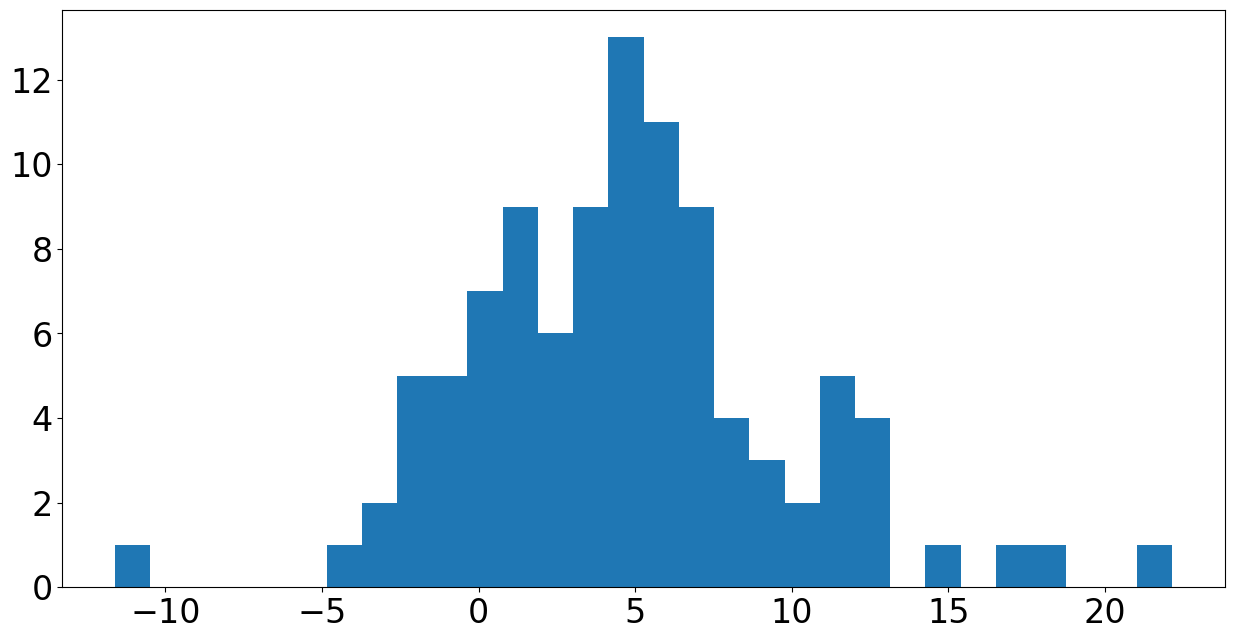

In [18]:
plt.hist(x[0,:],bins=30)

In [19]:
steps=100
L=50
eps=0.01
tx,trho,tu,tljs=flow(x,rho,u,steps,L,eps,gradlp,momentum='laplace',direction='fwd',xi=np.pi/16)

Starting forwards step
Initial x: [11.2113541]
Final x: [10.7113541]

Starting forwards step
Initial x: [10.7113541]
Final x: [10.2113541]

Starting forwards step
Initial x: [10.2113541]
Final x: [9.7113541]

Starting forwards step
Initial x: [9.7113541]
Final x: [9.4913541]

Starting forwards step
Initial x: [9.4913541]
Final x: [9.1913541]

Starting forwards step
Initial x: [9.1913541]
Final x: [8.7513541]

Starting forwards step
Initial x: [8.7513541]
Final x: [8.2513541]

Starting forwards step
Initial x: [8.2513541]
Final x: [7.7513541]

Starting forwards step
Initial x: [7.7513541]
Final x: [7.2513541]

Starting forwards step
Initial x: [7.2513541]
Final x: [7.0913541]

Starting forwards step
Initial x: [7.0913541]
Final x: [7.1313541]

Starting forwards step
Initial x: [7.1313541]
Final x: [7.0313541]

Starting forwards step
Initial x: [7.0313541]
Final x: [6.5313541]

Starting forwards step
Initial x: [6.5313541]
Final x: [6.3713541]

Starting forwards step
Initial x: [6.371354

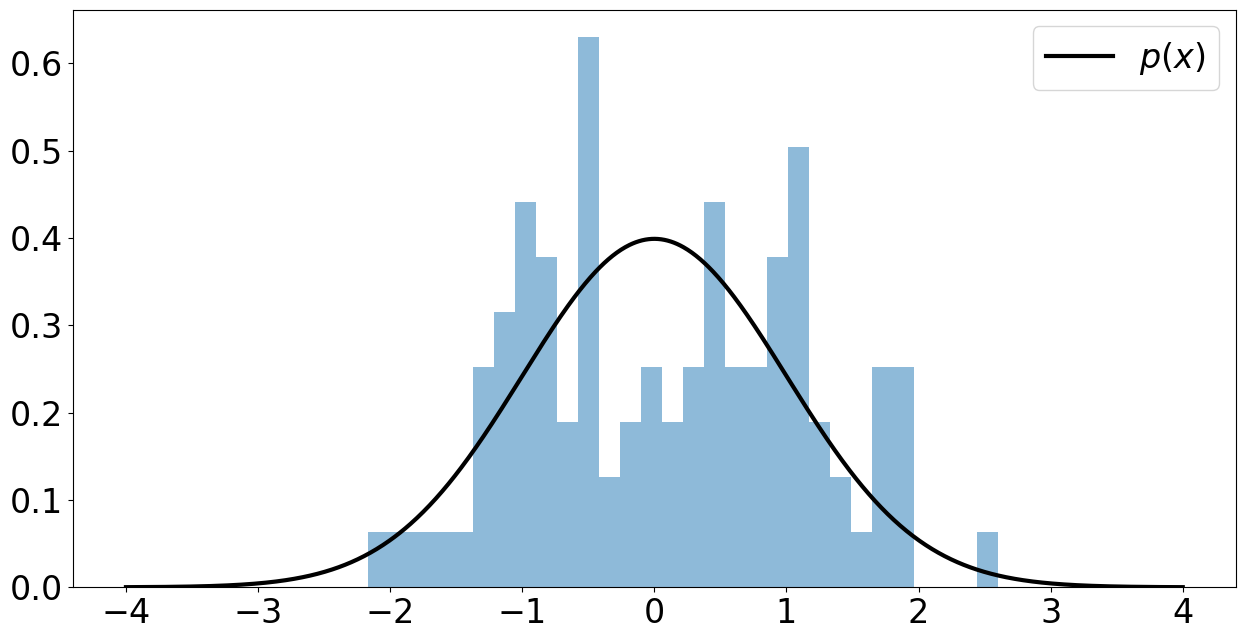

In [20]:
ls=np.linspace(-4,4,1000)
for m in range(M): plt.hist(tx[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$p(x)$')
plt.legend()

In [21]:
ttx,ttrho,ttu,tljs=flow(tx,trho,tu,steps,L,eps,gradlp,momentum='laplace',direction='bwd',xi=np.pi/16)

Starting backwards step
Initial x: [1.2513541]
Final x: [1.7513541]

Starting backwards step
Initial x: [1.7513541]
Final x: [2.2513541]

Starting backwards step
Initial x: [2.2513541]
Final x: [2.2713541]

Starting backwards step
Initial x: [2.2713541]
Final x: [1.7713541]

Starting backwards step
Initial x: [1.7713541]
Final x: [1.2713541]

Starting backwards step
Initial x: [1.2713541]
Final x: [1.6313541]

Starting backwards step
Initial x: [1.6313541]
Final x: [2.1313541]

Starting backwards step
Initial x: [2.1313541]
Final x: [1.8113541]

Starting backwards step
Initial x: [1.8113541]
Final x: [1.3113541]

Starting backwards step
Initial x: [1.3113541]
Final x: [1.1313541]

Starting backwards step
Initial x: [1.1313541]
Final x: [0.6313541]

Starting backwards step
Initial x: [0.6313541]
Final x: [0.1313541]

Starting backwards step
Initial x: [0.1313541]
Final x: [-0.3686459]

Starting backwards step
Initial x: [-0.3686459]
Final x: [0.1313541]

Starting backwards step
Initial 

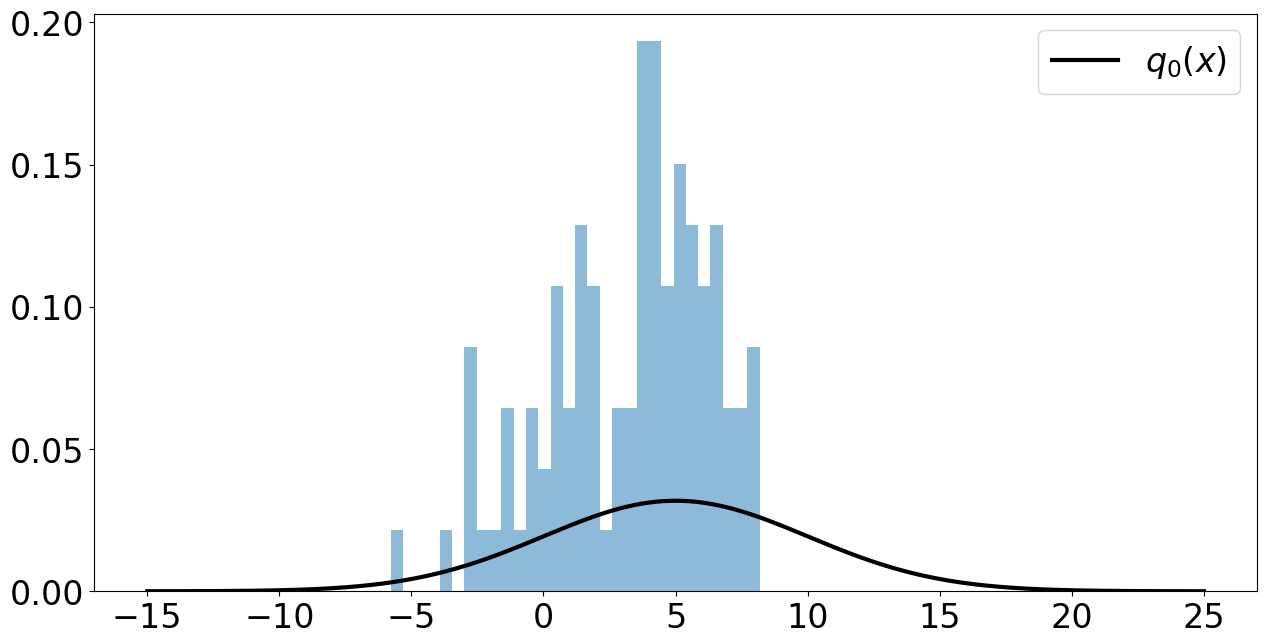

In [22]:
ls=np.linspace(5-4*sd,5+4*sd,1000)
for m in range(M): plt.hist(ttx[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(lq0(ls[np.newaxis,:],np.zeros((1,ls.shape[0])),0.5*np.ones(ls.shape[0]))),lw=3,c='black',label=r'$q_0(x)$')
plt.legend()

Starting backwards step
Initial x: [-4.]
Final x: [-3.5]

Starting backwards step
Initial x: [-3.5]
Final x: [-3.44]

Starting backwards step
Initial x: [-3.44]
Final x: [-3.92]

Starting backwards step
Initial x: [-3.92]
Final x: [-3.42]

Starting backwards step
Initial x: [-3.42]
Final x: [-2.92]

Starting backwards step
Initial x: [-2.92]
Final x: [-2.42]

Starting backwards step
Initial x: [-2.42]
Final x: [-1.92]

Starting backwards step
Initial x: [-1.92]
Final x: [-1.42]

Starting backwards step
Initial x: [-1.42]
Final x: [-0.92]

Starting backwards step
Initial x: [-0.92]
Final x: [-1.42]

Starting backwards step
Initial x: [-1.42]
Final x: [-1.92]

Starting backwards step
Initial x: [-1.92]
Final x: [-2.42]

Starting backwards step
Initial x: [-2.42]
Final x: [-2.92]

Starting backwards step
Initial x: [-2.92]
Final x: [-3.42]

Starting backwards step
Initial x: [-3.42]
Final x: [-2.92]

Starting backwards step
Initial x: [-2.92]
Final x: [-2.42]

Starting backwards step
Init

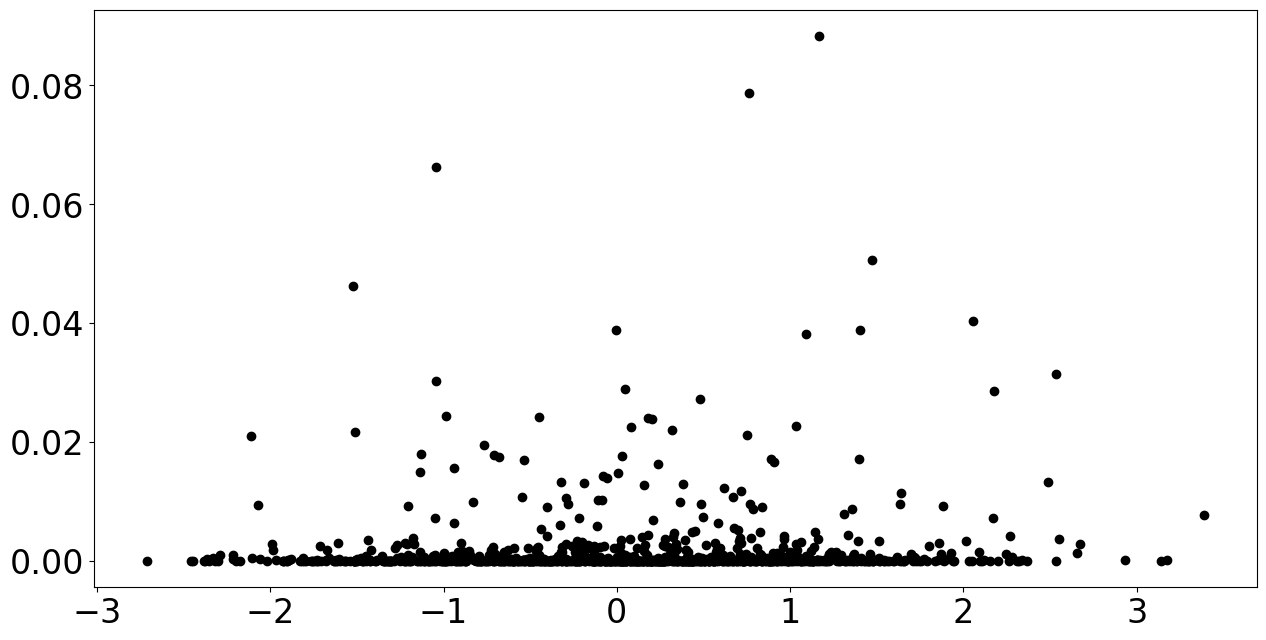

In [9]:
ls=np.linspace(-4,4,1000)
ttrho=np.zeros((1,ls.shape[0]))
ttu=0.5*np.ones(ls.shape[0])
plt.plot(ls,np.exp(lqN(ls[np.newaxis,:],ttrho,ttu,steps,L,eps,lq0,gradlp)),'ok')